# PrimeKG Analysis

## CSV → Graph

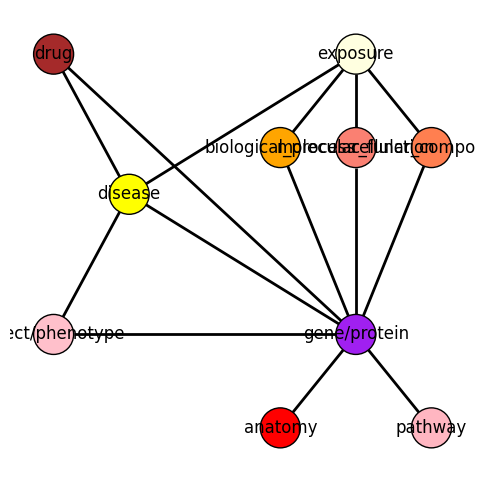

In [1]:
import igraph as ig
import matplotlib.pyplot as plt

# Define the nodes and their labels
nodes = ['drug', 'exposure', 'disease', 'effect/phenotype', 'gene/protein', 
         'anatomy', 'pathway', 'cellular_component', 'molecular_function', 'biological_process']

# Define edges between nodes
edges = [
    ('drug', 'disease'), ('drug', 'gene/protein'), 
    ('exposure', 'disease'), ('exposure', 'biological_process'), 
    ('exposure', 'cellular_component'), ('exposure', 'molecular_function'), 
    ('gene/protein', 'biological_process'), ('gene/protein', 'cellular_component'), 
    ('gene/protein', 'molecular_function'), ('disease', 'gene/protein'), 
    ('effect/phenotype', 'disease'), ('effect/phenotype', 'gene/protein'), 
    ('gene/protein', 'anatomy'), ('gene/protein', 'pathway')
]

# Create a directed graph
g = ig.Graph()

# Add vertices (nodes)
g.add_vertices(nodes)

# Add edges
g.add_edges(edges)

# Define the positions for each node
pos = {
    "drug": (0, 3), 
    "exposure": (4, 3),
    "disease": (1, 1.5), 
    "effect/phenotype": (0, 0), 
    "gene/protein": (4, 0), 
    "anatomy": (3, -1), 
    "pathway": (5, -1),
    "cellular_component": (5, 2), 
    "molecular_function": (4, 2), 
    "biological_process": (3, 2)
}

# Set node colors (optional: to match your previous example)
color_dict = {
    'drug': 'brown', 'disease': 'yellow', 'effect/phenotype': 'pink', 'exposure': 'lightyellow',
    'gene/protein': 'purple', 'pathway': 'lightpink', 'anatomy': 'red',
    'biological_process': 'orange', 'cellular_component': 'coral', 'molecular_function': 'salmon'
}
colors = [color_dict[node] for node in nodes]

# Convert pos dictionary to a list of tuples matching igraph layout format
layout = [pos[node] for node in nodes]

# Plot the graph using the predefined layout
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the graph
ig.plot(g, target=ax, layout=layout, vertex_label=nodes, vertex_color=colors, 
        vertex_size=40, edge_color="black", edge_width=2)

plt.show()

In [5]:
from PrimeKG_analysis import *
import sys
sys.path.append('..')
from PrimeKG import *


CSV to pandas Dataframe

In [6]:
import pandas as pd

primekg = pd.read_csv('../PrimeKG.csv', low_memory=False)

primekg.head()

,relation,display_relation,x_index,x_id,x_type,x_name,x_source,y_index,y_id,y_type,y_name,y_source
0,protein_protein,ppi,0,9796,gene/protein,PHYHIP,NCBI,8889,56992,gene/protein,KIF15,NCBI
1,protein_protein,ppi,1,7918,gene/protein,GPANK1,NCBI,2798,9240,gene/protein,PNMA1,NCBI
2,protein_protein,ppi,2,8233,gene/protein,ZRSR2,NCBI,5646,23548,gene/protein,TTC33,NCBI
3,protein_protein,ppi,3,4899,gene/protein,NRF1,NCBI,11592,11253,gene/protein,MAN1B1,NCBI
4,protein_protein,ppi,4,5297,gene/protein,PI4KA,NCBI,2122,8601,gene/protein,RGS20,NCBI


pandas Dataframe to igraph.Graph (undirected)

* create node Dataframe
    <!-- * Concatenates two parts of the KG: 'x' nodes and 'y' nodes.
    * Renames columns to have consistent names (node_id, node_type, node_name, node_source).
    * Removes duplicates and resets the index, creating a 'node_idx' column. -->

In [7]:
nodes = create_primekg_node_df(primekg)

* create edge Dataframe
    <!-- * Merges the original KG with the nodes dataframe twice (once for 'x' nodes, once for 'y' nodes).
    * Renames the merged 'node_idx' columns to 'x_idx' and 'y_idx'.
    * Keeps only relevant columns: relation, display_relation, x_idx, y_idx.
    * Creates a 'combine_idx' column by concatenating x_idx and y_idx as strings. -->

In [8]:
edges = create_primekg_edge_df(primekg, nodes)
edges.head()

,relation,display_relation,x_idx,y_idx
0,protein_protein,ppi,0,8889
1,protein_protein,ppi,1,2798
2,protein_protein,ppi,2,5646
3,protein_protein,ppi,3,11592
4,protein_protein,ppi,4,2122


* create the edge_index
    <!-- * Extracts 'x_idx' and 'y_idx' columns and transposes them to create an edge list. -->

In [9]:
edge_index = create_primekg_edge_index(edges)

* build igraph.Graph()

In [10]:
graph = dfs_to_graph(nodes, edges)

## Type distribution

### Node types

In [11]:
print("Total number of nodes: ", len(nodes))
n_node_type = nodes['node_type'].value_counts()
n_node_type

Total number of nodes:  129430


node_type
biological_process    28642
gene/protein          27671
disease               17135
effect/phenotype      15311
anatomy               14035
molecular_function    11169
drug                   7957
cellular_component     4176
pathway                2516
exposure                818
Name: count, dtype: int64

In [12]:
nodes[nodes['node_type'] == 'disease'].head()

,node_idx,node_id,node_type,node_name,node_source
27158,27158,13924_12592_14672_13460_12591_12536_30861_8146...,disease,osteogenesis imperfecta,MONDO_grouped
27159,27159,11160_13119_13978_12060_12327_12670_13210_1106...,disease,autosomal recessive nonsyndromic deafness,MONDO_grouped
27160,27160,8099_12497_12498,disease,congenital stationary night blindness autosoma...,MONDO_grouped
27161,27161,14854_14293_14470_12380_11832_14603_14853_1176...,disease,autosomal dominant nonsyndromic deafness,MONDO_grouped
27162,27162,33202_32776_30905_33670_33200_32740_32732_3320...,disease,"deafness, autosomal recessive",MONDO_grouped


### Edge types

In [13]:
print("Total number of nodes: ", len(edges))
n_edge_type = edges['relation'].value_counts()
n_edge_type

Total number of nodes:  8104838


relation
anatomy_protein_present       3036406
drug_drug                     2672628
protein_protein                642150
disease_phenotype_positive     304034
bioprocess_protein             289610
cellcomp_protein               166804
disease_protein                161322
molfunc_protein                139060
drug_effect                    129568
bioprocess_bioprocess          105772
pathway_protein                 85292
disease_disease                 64718
contraindication                61422
drug_protein                    51306
anatomy_protein_absent          39774
phenotype_phenotype             37472
anatomy_anatomy                 28064
molfunc_molfunc                 27148
indication                      18790
cellcomp_cellcomp                9690
phenotype_protein                6660
off-label use                    5136
pathway_pathway                  5070
exposure_disease                 4608
exposure_exposure                4140
exposure_bioprocess              3250
exp

### Edge distribution between node types

![Node Type Hypergraph](./node_types_hypergraph.png)

Each row shows the number of edges that connect nodes of different types.

In [14]:
links_per_node_t = links_per_node_type(edge_index, nodes)

In [15]:
contrarelation_edges_index = edges[edges['relation']=="indication"].get(['x_idx', 'y_idx']).values
links_per_node_type(contrarelation_edges_index, nodes)

y_node_type,disease,drug
x_node_type,,
disease,0,9395
drug,9395,0


In [16]:
contrarelation_edges_index = edges[edges['relation']=="contraindication"].get(['x_idx', 'y_idx']).values
links_per_node_type(contrarelation_edges_index, nodes)

y_node_type,disease,drug
x_node_type,,
disease,0,30711
drug,30711,0


In [17]:
contrarelation_edges_index = edges[edges['relation']=="off-label use"].get(['x_idx', 'y_idx']).values
links_per_node_type(contrarelation_edges_index, nodes)

y_node_type,disease,drug
x_node_type,,
disease,0,2568
drug,2568,0


How all edges are distributed between node types. Note that the resulting matrix is symmetric.

In [18]:
total_sum = links_per_node_t.sum().sum()

percentage_total = (links_per_node_t / total_sum) * 100
percentage_total.round(3)

y_node_type,anatomy,biological_process,cellular_component,disease,drug,effect/phenotype,exposure,gene/protein,molecular_function,pathway
x_node_type,,,,,,,,,,
anatomy,0.346,0.000,0.000,0.000,0.000,0.000,0.000,18.977,0.000,0.000
biological_process,0.000,1.305,0.000,0.000,0.000,0.000,0.020,1.787,0.000,0.000
cellular_component,0.000,0.000,0.120,0.000,0.000,0.000,0.000,1.029,0.000,0.000
disease,0.000,0.000,0.000,0.799,0.527,1.891,0.028,0.995,0.000,0.000
drug,0.000,0.000,0.000,0.527,32.976,0.799,0.000,0.317,0.000,0.000
effect/phenotype,0.000,0.000,0.000,1.891,0.799,0.462,0.000,0.041,0.000,0.000
exposure,0.000,0.020,0.000,0.028,0.000,0.000,0.051,0.015,0.001,0.000
gene/protein,18.977,1.787,1.029,0.995,0.317,0.041,0.015,7.923,0.858,0.526
molecular_function,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.858,0.335,0.000


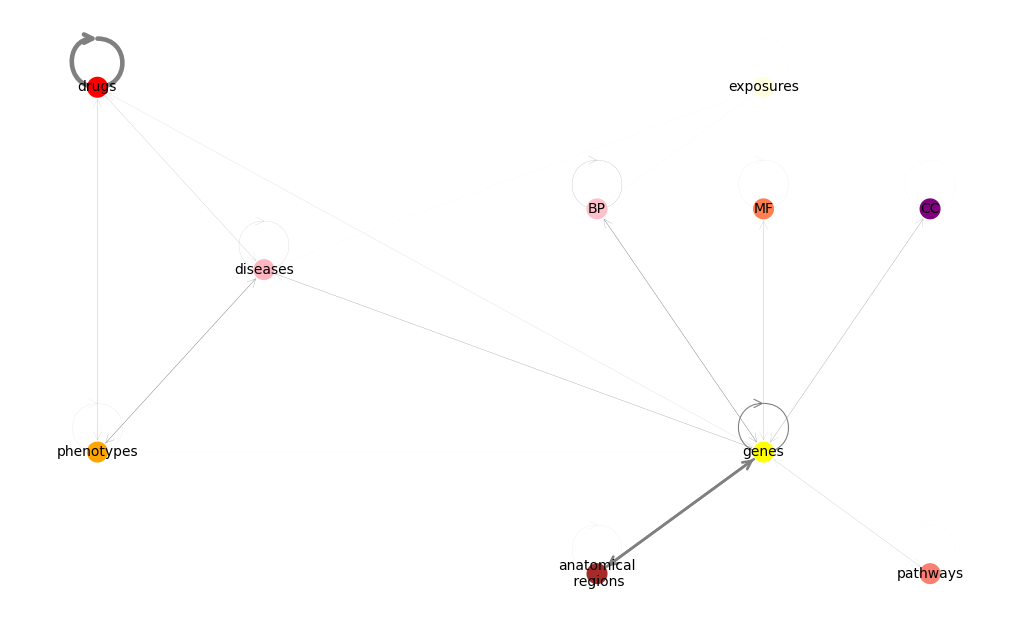

In [19]:
weighed_hypergraph_node_types(percentage_total, 0)

Given a node type for each row, the dataframe shows the distribution of all exiting edges towards the possibile node types.

In [22]:
percentage_link_counts = links_per_node_t.div(links_per_node_t.sum(axis=1), axis=0) * 100

percentage_link_counts.round(3)

y_node_type,anatomy,biological_process,cellular_component,disease,drug,effect/phenotype,exposure,gene/protein,molecular_function,pathway
x_node_type,,,,,,,,,,
anatomy,1.792,0.000,0.000,0.000,0.000,0.000,0.000,98.208,0.000,0.000
biological_process,0.000,41.939,0.000,0.000,0.000,0.000,0.644,57.416,0.000,0.000
cellular_component,0.000,0.000,10.408,0.000,0.000,0.000,0.011,89.581,0.000,0.000
disease,0.000,0.000,0.000,18.836,12.420,44.596,0.671,23.477,0.000,0.000
drug,0.000,0.000,0.000,1.521,95.256,2.309,0.000,0.914,0.000,0.000
effect/phenotype,0.000,0.000,0.000,59.203,25.032,14.479,0.000,1.287,0.000,0.000
exposure,0.000,17.406,0.107,24.679,0.000,0.000,44.344,12.982,0.482,0.000
gene/protein,58.450,5.503,3.169,3.065,0.975,0.127,0.046,24.403,2.642,1.621
molecular_function,0.000,0.000,0.000,0.000,0.000,0.000,0.047,71.886,28.068,0.000


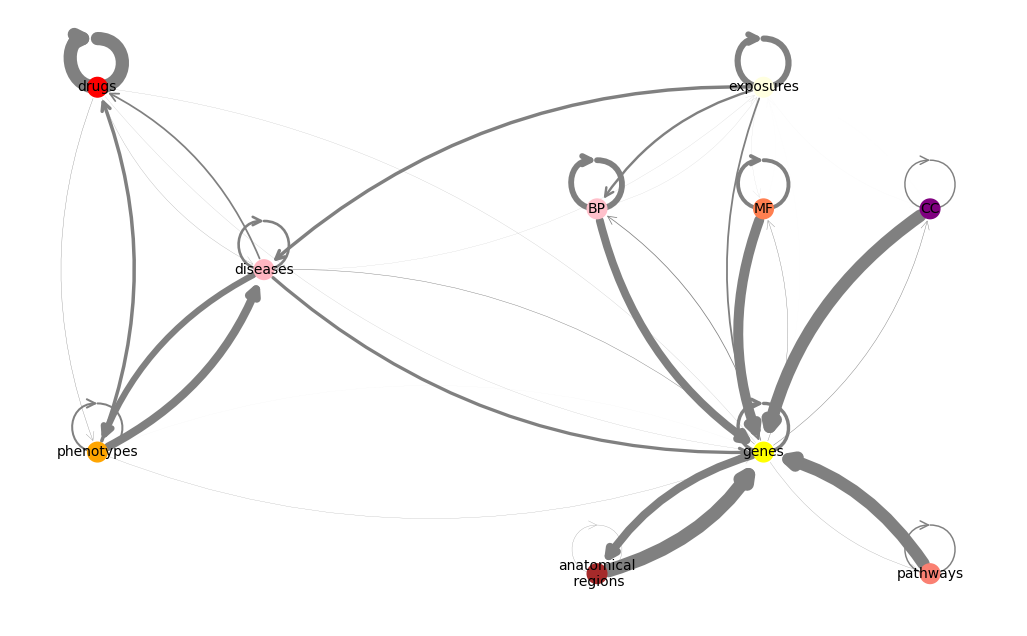

In [23]:
weighed_hypergraph_node_types(percentage_link_counts, 0.2)

## Connectivity

### Neighbourhood sizes per type

AttributeError: 'NoneType' object has no attribute 'vs'

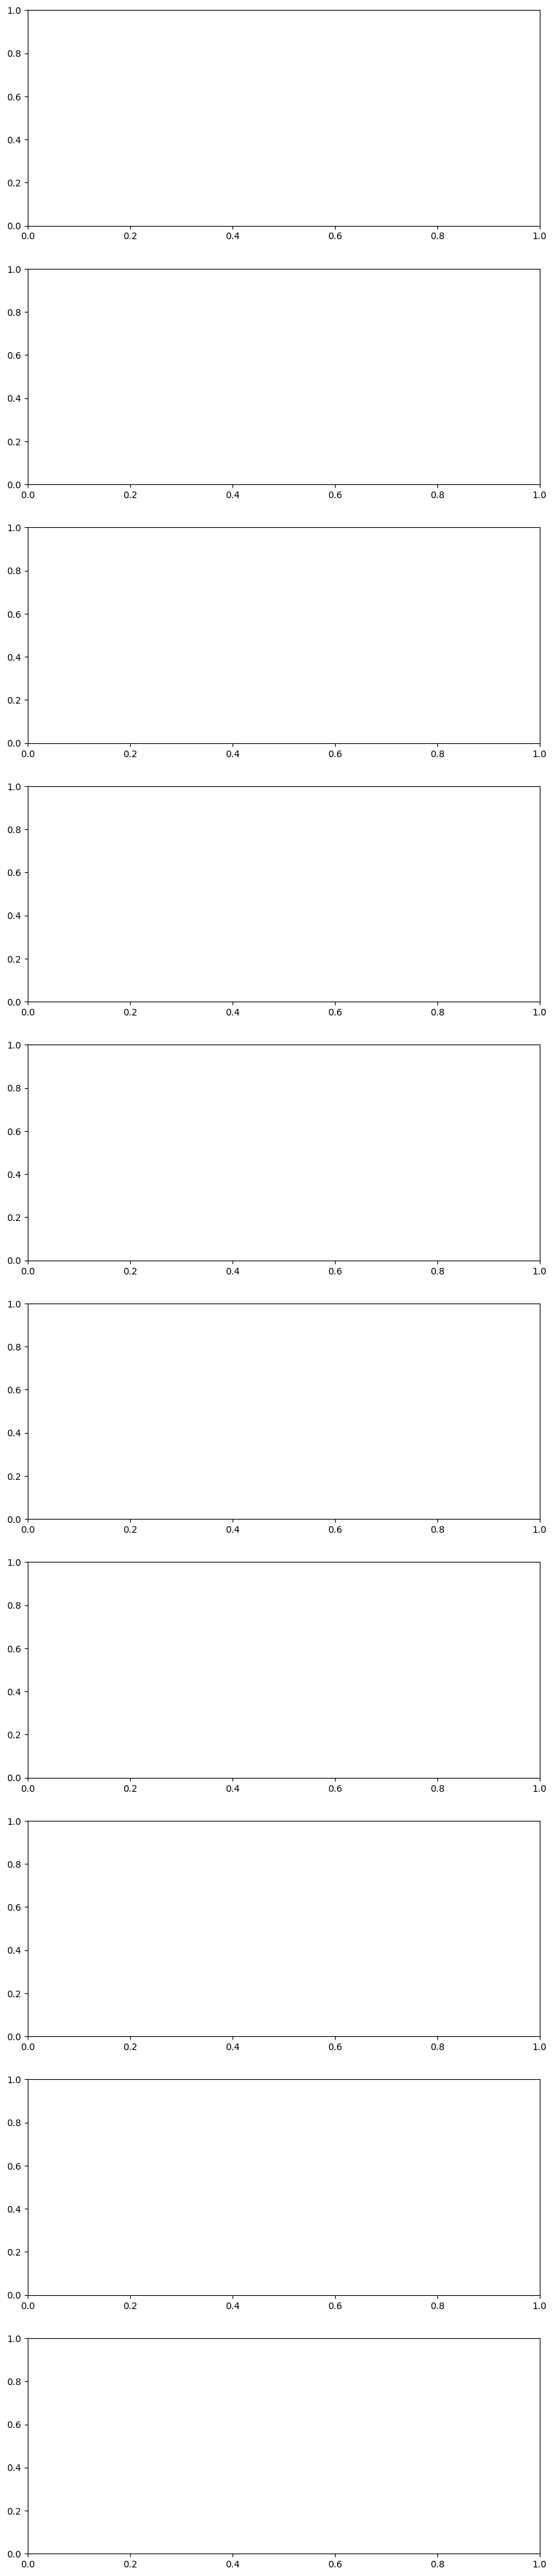

In [24]:
node_types = nodes['node_type'].unique()

fig, axes = plt.subplots(len(node_types), 1, figsize=(10, 5*len(node_types)))
for ax, node_type in zip(axes, node_types):
    plot_degree_distribution(ax, graph, node_type)
plt.tight_layout()
plt.show()   

In [20]:
is_strongly_connected = graph.is_connected(mode="strong")
print(f"Is the graph strongly connected? {is_strongly_connected}")

is_weakly_connected = graph.is_connected(mode="weak")
print(f"Is the graph weakly connected? \t {is_weakly_connected}")

Is the graph strongly connected? True
Is the graph weakly connected? 	 True


## Clusterability

[igraph.modularity(membership_vector)](https://r.igraph.org/reference/modularity.igraph.html) measures how well a network is divided into communities compared to a random graph with the same degree distribution 
* modularity $\sim 1$ → well formed communities with 
* modularity $\sim 0$ → community structure is weak or indistinguishable from random with modularity

[igraph.community_multilevel](https://igraph.org/c/doc/igraph-Community.html#igraph_community_multilevel) optimize modularity greedily

[igraph.community_label_propagation](https://journals.aps.org/pre/pdf/10.1103/PhysRevE.76.036106) labels spread across neighbours - node labels updated according to random permutation until convergence

[igraph.community_leading_eigenvector](https://igraph.org/c/doc/igraph-Community.html#igraph_community_leading_eigenvector)  maximization of modularity benefit function can be written in terms of the eigenspectrum of a matrix (modularity matrix)




In [21]:
clustering_methods = lambda graph: [graph.community_multilevel, graph.community_label_propagation, graph.community_leading_eigenvector]

for method in clustering_methods(graph):
    num_clusters, mod = clustering_info(graph, method)
    print(f"{method.__name__}\n---------------------------------\n Number of communities: {num_clusters}\n Modularity score: {mod}\n")

_community_multilevel
---------------------------------
 Number of communities: 648
 Modularity score: 0.5224925788619827

_community_label_propagation
---------------------------------
 Number of communities: 2684
 Modularity score: 0.5010886732002506

_community_leading_eigenvector
---------------------------------
 Number of communities: 3
 Modularity score: 0.49937096577943124



Transitivity: how often nodes that are neighbors of a given node are also neighbors of each other - ratio of triangles vs triplets

In [22]:
graph.transitivity_undirected()

0.07828268762711252

In [23]:
graph.transitivity_avglocal_undirected()

0.10220144435862362